### American Gut Project File Metadata:


   - get file metadata from European Nucleotide Archive, and from SRA/NCBI
   - Remove samples not sampling the human gut metagenome
   - return list of ftp paths to download the remaining files
   - return file metadata in csv
   - return sample metadata in csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##### Metadata from ENA:

In [2]:
file_data = pd.read_csv("~/Desktop/Metadata/ENAfileInfo.txt", sep ="\t")
print(file_data.shape)
file_data.head()

(25411, 5)


,sample_accession,secondary_sample_accession,run_accession,run_alias,fastq_ftp
0,SAMEA3607589,ERS914738,ERR1072624,qiita_ppdid_614:10317.000001002,ftp.sra.ebi.ac.uk/vol1/fastq/ERR107/004/ERR107...
1,SAMEA3607590,ERS914739,ERR1072625,qiita_ppdid_614:10317.000001004,ftp.sra.ebi.ac.uk/vol1/fastq/ERR107/005/ERR107...
2,SAMEA3607591,ERS914740,ERR1072626,qiita_ppdid_614:10317.000001008,ftp.sra.ebi.ac.uk/vol1/fastq/ERR107/006/ERR107...
3,SAMEA3607592,ERS914741,ERR1072627,qiita_ppdid_614:10317.000001018,ftp.sra.ebi.ac.uk/vol1/fastq/ERR107/007/ERR107...
4,SAMEA3607593,ERS914742,ERR1072628,qiita_ppdid_614:10317.000001028,ftp.sra.ebi.ac.uk/vol1/fastq/ERR107/008/ERR107...


##### Metadata from SRA:

In [3]:
sra_data = pd.read_csv("~/Desktop/Metadata/SraRunInfo.csv")
print(sra_data.shape)

(25411, 47)


In [4]:
print(sra_data["ScientificName"].value_counts())

human gut metagenome               19990
metagenome                          2147
human oral metagenome               1382
human skin metagenome               1239
metagenomes                          258
human nasopharyngeal metagenome      207
human metagenome                      72
human eye metagenome                  54
human vaginal metagenome              45
food metagenome                       10
vaginal metagenome                     5
feces metagenome                       1
gut metagenome                         1
Name: ScientificName, dtype: int64


In [5]:
sra_gut_data = sra_data[sra_data["ScientificName"] == "human gut metagenome"]
cols = ["Run","spots","bases","avgLength","LibraryName","Platform","Model","Sample", "BioSample","Sex", "Submission"]
sra_gut_data = sra_gut_data.loc[:, cols]

In [6]:
### Keep ENA metadata of samples from the human ut metagenome (Sample site not included in ENA)
file_data_keep = file_data[file_data["run_accession"].isin(sra_gut_data["Run"])]
print file_data_keep.shape

(19990, 5)


In [7]:
file_data_keep.index = file_data_keep["run_accession"]
sra_gut_data.index = sra_gut_data["Run"]
cols = ["fastq_ftp"]
file_data_keep = file_data_keep.loc[:, cols]

##### Combined File Metadata (SRA /ENA)

In [8]:
full_data = pd.concat([file_data_keep, sra_gut_data], axis=1, sort=False)
print(full_data.shape)
full_data.head()

(19990, 12)


,fastq_ftp,Run,spots,bases,avgLength,LibraryName,Platform,Model,Sample,BioSample,Sex,Submission
ERR1072624,ftp.sra.ebi.ac.uk/vol1/fastq/ERR107/004/ERR107...,ERR1072624,17838,2688198,150,10317.000001002,ILLUMINA,Illumina MiSeq,ERS914738,SAMEA3607589,female,ERA524627
ERR1072625,ftp.sra.ebi.ac.uk/vol1/fastq/ERR107/005/ERR107...,ERR1072625,21267,3198000,150,10317.000001004,ILLUMINA,Illumina MiSeq,ERS914739,SAMEA3607590,female,ERA524627
ERR1072626,ftp.sra.ebi.ac.uk/vol1/fastq/ERR107/006/ERR107...,ERR1072626,25136,3787410,150,10317.000001008,ILLUMINA,Illumina MiSeq,ERS914740,SAMEA3607591,female,ERA524627
ERR1072627,ftp.sra.ebi.ac.uk/vol1/fastq/ERR107/007/ERR107...,ERR1072627,8842,1326488,150,10317.000001018,ILLUMINA,Illumina MiSeq,ERS914741,SAMEA3607592,male,ERA524627
ERR1072628,ftp.sra.ebi.ac.uk/vol1/fastq/ERR107/008/ERR107...,ERR1072628,24918,3753923,150,10317.000001028,ILLUMINA,Illumina MiSeq,ERS914742,SAMEA3607593,female,ERA524627


##### Value counts of average sequence length of all samples:

In [9]:
print(full_data['avgLength'].value_counts())

150    14951
151     3466
126      429
149      388
148      308
139       97
138       94
140       53
147       37
137       33
141       32
142       26
143       18
146       17
136       12
145        9
144        7
135        5
99         4
133        2
134        1
131        1
Name: avgLength, dtype: int64


##### Value Counts of Instruments used to process samples:


- important process fastq files processed using different instruments seperately into OTU tables (using Dada2)
- Seperate OTU table will be merged after confirming that the they do not cluster significantly by processing instrument

In [10]:
print(full_data['Model'].value_counts())

Illumina MiSeq         17417
Illumina HiSeq 2500     2144
Illumina HiSeq 2000      429
Name: Model, dtype: int64


- seperate file names into different files to be downloaded (ftp) into different folders


In [11]:
HiSeq2500_list = full_data.loc[full_data['Model'] == 'Illumina HiSeq 2500', "Run"]
HiSeq2000_list = full_data.loc[full_data['Model'] == 'Illumina HiSeq 2000', "Run"]
MiSeq_list = full_data.loc[full_data['Model'] == 'Illumina MiSeq', "Run"]
MiSeq_list = MiSeq_list.sample(frac = 1) ##shuffling list (make sure larger files are distributed evenly)


HiSeq2500_list.to_csv("./File_lists/HiSeq2500_list.txt", index = False)
HiSeq2000_list.to_csv("./File_lists/HiSeq2000_list.txt", index = False)
MiSeq_list.to_csv("./File_lists/MiSeq_list.txt", index = False)

##### Histogram of Sequencing Depth over all samples (outliers clipped):

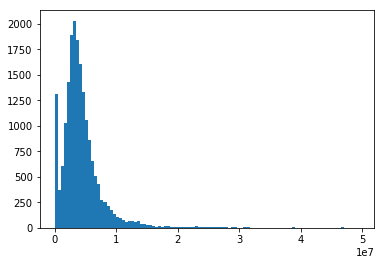

In [12]:
plot_data = full_data.loc[full_data["bases"] < 0.5e8,"bases"]
plt.hist(plot_data, bins = 100)
plt.show()


In [13]:
temp = full_data[full_data["fastq_ftp"] == np.nan]
temp.head()

,fastq_ftp,Run,spots,bases,avgLength,LibraryName,Platform,Model,Sample,BioSample,Sex,Submission


In [14]:
full_data.to_csv("./AGPFileMetadata.txt", index = False)
full_data["fastq_ftp"].to_csv("./File_lists/FastqList.txt", index = False)